In [ ]:
!pip install transformers datasets evaluate seqeval pyarrow==14.0.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from transformers import AutoTokenizer
from transformers import AutoConfig
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

from datasets import Dataset


from copy import deepcopy
import pandas as pd
import numpy as np
import random
import joblib
import ast
import gc

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
judgement = pd.read_csv('/content/drive/MyDrive/legal_NER/data/NER_TRAIN/train_judgement_bio.csv')
judgement.shape

(9435, 2)

In [ ]:
df = judgement.sample(frac=1, random_state=42).copy()
df = df.rename({'BIO_tags': 'tags'}, axis=1)
df.head()

,tokens,tags
4613,"['Clause', '18(1', ')', ',', '(', '2', ')', 'a...","['B-PROVISION', 'I-PROVISION', 'I-PROVISION', ..."
1103,"['The', 'order', 'can', 'not', 'be', 'said', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
5214,"['Ajit', 'Kumar', 'Guha', '(', 'D.', 'W.', '1'...","['B-WITNESS', 'I-WITNESS', 'I-WITNESS', 'O', '..."
3315,"['The', 'purpose', 'of', 'entering', 'into', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
5363,"['It', 'is', 'admitted', 'that', 'the', 'vehic...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [ ]:
def convert_to_list(s):
    return ast.literal_eval(s)

df['tokens'] = df['tokens'].apply(convert_to_list)
df['tags'] = df['tags'].apply(convert_to_list)
df.head()

,tokens,tags
4613,"[Clause, 18(1, ), ,, (, 2, ), and, (, 3, ), \n...","[B-PROVISION, I-PROVISION, I-PROVISION, I-PROV..."
1103,"[The, order, can, not, be, said, to, be, wrong...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5214,"[Ajit, Kumar, Guha, (, D., W., 1, ), ,, who, w...","[B-WITNESS, I-WITNESS, I-WITNESS, O, O, O, O, ..."
3315,"[The, purpose, of, entering, into, a, contract...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5363,"[It, is, admitted, that, the, vehicle, bearing...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
def remove_BIO(tags):
  new_tags = []
  for tag in tags:
    new_tags.append(tag.replace('I-', '').replace('B-', ''))

  return new_tags

df['tags'] = df['tags'].apply(remove_BIO)
df['tags'].head()

4613    [PROVISION, PROVISION, PROVISION, PROVISION, P...
1103    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
5214    [WITNESS, WITNESS, WITNESS, O, O, O, O, O, O, ...
3315    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
5363    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
Name: tags, dtype: object

In [ ]:
tag_list = df['tags'].values
labels = [label for tags in tag_list  for label in tags]
labels = list(set(labels))
print(labels)
print(len(labels))

['COURT', 'JUDGE', 'WITNESS', 'STATUTE', 'PETITIONER', 'DATE', 'OTHER_PERSON', 'PRECEDENT', 'O', 'RESPONDENT', 'GPE', 'CASE_NUMBER', 'PROVISION', 'ORG']
14


In [ ]:
dataset = df.values.tolist()
for data in dataset:
    print(data[0])
    print(data[1])
    break

['Clause', '18(1', ')', ',', '(', '2', ')', 'and', '(', '3', ')', '\n', '(', 'a', ')', '&', '(', 'b', ')', 'were', 'transposed', 'in', 'Article', '23', 'of', 'the', 'Draft', 'Constitution', 'of', 'India', '.']
['PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'PROVISION', 'O', 'O', 'O', 'PROVISION', 'PROVISION', 'O', 'O', 'STATUTE', 'STATUTE', 'STATUTE', 'STATUTE', 'O']


In [ ]:
class TrainSampler:
    '''
    Samples the data from csv to episodic data with query and support set in N-way K-shot
    n_wa: numeber of classes
    k_shot: sample for each class
    '''
    def __init__(self, n_way):
        self.n_way = n_way

    def extract_n_way_data(self, data):
        n_way_data = []
        for items in data:
            if len(set(items[1]))==self.n_way:
                n_way_data.append(items)

        return n_way_data

    def sample_data(self, n_way_data, full_data, n_episodes):
        episodes = []
        random.seed(42)
        for query in random.sample(n_way_data, min(n_episodes, len(n_way_data))):

            query_text = query[0]
            query_tags = query[1]

            query_tag_set = set(query_tags)

            final_query_set = [query_text, query_tags]

            support_data = []
            class_counts = {k: 0 for k in query_tag_set}

            for items in random.sample(full_data, len(full_data)):
                if len(support_data)>=8:
                        break
                text, labels = items
                new_labels = []
                for i in range(len(labels)):
                    if labels[i] not in query_tag_set:
                        new_labels.append('O')
                    else:
                        new_labels.append(labels[i])


                for tag in query_tag_set:
                    if len(support_data)>=8:
                        break
                    if [text, new_labels] in support_data or ''.join(text) == ''.join(query_text):
                        break
                    if len(set(new_labels))<2:
                        break
                    if tag in new_labels and class_counts[tag]<2:
                        support_data.append([text, new_labels])
                        for ent in set(new_labels):
                                class_counts[ent]+=1



            if len(support_data)<8:
                for items in random.sample(full_data, 8):
                    if len(support_data)>=8:
                        break
                    text, labels = items
                    new_labels = []
                    for i in range(len(labels)):
                        if labels[i] not in query_tag_set:
                            new_labels.append('O')
                        else:
                            new_labels.append(labels[i])

                    if [text, new_labels] in support_data or ''.join(text) == ''.join(query_text):
                        break

                    support_data.append([text, new_labels])


            episodes.append({
                'query_set': final_query_set,
                'support_set': support_data
            })

            n_way_data.remove(query)

        return episodes

    def generate_episodes(self, reference_data, num_episodes):
        extracted_data = self.extract_n_way_data(reference_data)
        episodes = self.sample_data(extracted_data, reference_data, num_episodes)

        return episodes

In [ ]:
sampler = TrainSampler(n_way=5)

In [ ]:
episodes = sampler.generate_episodes(dataset, 500)
len(episodes)

401

In [ ]:
xlmr_model_name = "xlm-roberta-base"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
def tokenize_and_align_labels(support_set, q_tokens, q_tags, eval=False):

  # For support

  tokenized_support_set = []
  label2idx = {}
  idx = 0
  for items in support_set:
    s_tokens, s_tags = items
    s_tokenized = xlmr_tokenizer(s_tokens, truncation=True, is_split_into_words=True)

    for tag in s_tags:
      if tag not in label2idx:
        label2idx[tag] = idx
        idx+=1

    labels = [label2idx[tag] for tag in s_tags]
    word_ids = s_tokenized.word_ids()

    label_ids = []
    for word_idx in word_ids:
      if word_idx==None:
        label_ids.append(label2idx['O'])
      else:
        label_ids.append(labels[word_idx])

    s_tokenized['labels'] = label_ids

    tokenized_support_set.append(s_tokenized)


  # For query
  q_tokenized_inputs = xlmr_tokenizer(q_tokens, truncation=True, is_split_into_words=True)

  if not eval:
    q_word_ids = q_tokenized_inputs.word_ids()
    q_labels = [label2idx[tag] for tag in q_tags]
    q_label_ids = []
    for word_idx in q_word_ids:
      if word_idx==None:
        q_label_ids.append(label2idx['O'])
      else:
        q_label_ids.append(q_labels[word_idx])

    q_tokenized_inputs['labels'] = q_label_ids
  else:
    q_tokenized_inputs['labels'] = []

  return q_tokenized_inputs, tokenized_support_set, label2idx

In [ ]:
def tokenize_episodes(episodes, eval=False):

    tokenized_episodes = []

    for episode in episodes:

        final_support_set = []
        final_query_set = []
        query = episode['query_set']
        support = episode['support_set']

        q_tokens, q_tags = query

        tokenized_query_set, tokenized_support_set, label2idx = tokenize_and_align_labels(support, q_tokens, q_tags, eval=eval)

        if len(final_query_set)<1:
            q_ii = torch.tensor(tokenized_query_set['input_ids']).unsqueeze(0)
            q_am = torch.tensor(tokenized_query_set['attention_mask']).unsqueeze(0)
            q_l = torch.tensor(tokenized_query_set['labels'])
            final_query_set.extend([q_ii, q_am, q_l])

        for support_set in tokenized_support_set:
            s_ii = torch.tensor(support_set['input_ids']).unsqueeze(0)
            s_am = torch.tensor(support_set['attention_mask']).unsqueeze(0)
            s_l = torch.tensor(support_set['labels'], dtype=torch.int)
            final_support_set.append([s_ii, s_am, s_l])

        tokenized_episodes.append({
            'query_set': final_query_set,
            'support_set': final_support_set,
            'label2idx': label2idx
        })

    return tokenized_episodes

In [ ]:
tokenized_episodes = tokenize_episodes(episodes)

In [ ]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig
  def __init__(self, config):
    super().__init__(config)

    # load model body
    self.roberta = RobertaModel(config, add_pooling_layer=False)

    # load and initialize weights
    self.init_weights()

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):

    # use model body to get encoder representation
    outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)

    return outputs

In [ ]:
class PrototypicalNetworksNER(nn.Module):
    def __init__(self, encoder, hidden_size, prototype_size):
        super(PrototypicalNetworksNER, self).__init__()

        # self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.prototype_size = prototype_size
        self.encoder = encoder
        self.fc1 = nn.Linear(hidden_size, prototype_size)


    def build_prototypes(self, support_set, num_classes, get_prototypes=False):

      prototypes = torch.zeros(num_classes, self.prototype_size).to(device)
      all_prototypes = [[] for clas in range(num_classes)]
      # count of each class
      class_counts = torch.zeros(num_classes).to(device)
      for hidden_states, labels in support_set:
        for hidden_state, label in zip(hidden_states.squeeze(), labels):

          prototype = self.fc1(hidden_state)
          prototypes[label] += prototype.to(device)
          class_counts[label]+=1

          if get_prototypes:
            all_prototypes[label].append(prototype)
      # mean
      prototypes = prototypes/class_counts.unsqueeze(1)
      prototypes = torch.nan_to_num(prototypes, 0.)
      if get_prototypes:
        return prototypes, all_prototypes
      return prototypes


    def predict_query_set(self, query_set, prototypes):
        distances = []
        for hidden_states in query_set:
          hidden_states = hidden_states.squeeze()
          q_prototype = self.fc1(hidden_states)
          distance = torch.cdist(q_prototype, prototypes)
          # To get the closest prototype
          # predicted_labels = F.softmax(distances, dim=1)
          distances.append(distance)
        return distances

    def forward(self, support_set, query_set, num_classes, get_prototypes=False):
        '''
        input:
            Tokenized Support Set
            Tokenized Query Set

        Output of encoder (Roberta Model)
            sequence output: (1, 256, 768)

        Final Outputs:
            Distances
        '''

        hidden_support_set, hidden_query_set = [], []
        for item in support_set:
          s_input_ids, s_attention_mask, s_labels = item
          s_hidden_states = self.encoder(input_ids=s_input_ids.to(device), attention_mask=s_attention_mask.to(device))['last_hidden_state']
          hidden_support_set.append([s_hidden_states, s_labels])
        if get_prototypes:
          prototypes, all_protos = self.build_prototypes(hidden_support_set, num_classes, get_prototypes)
        else:
          prototypes = self.build_prototypes(hidden_support_set, num_classes)

        q_input_ids, q_attention_mask, q_labels = query_set
        q_hidden_states = self.encoder(input_ids=q_input_ids.to(device), attention_mask=q_attention_mask.to(device))['last_hidden_state']
        hidden_query_set.append(q_hidden_states)

        predictions = self.predict_query_set(hidden_query_set, prototypes)

        del hidden_support_set
        del hidden_query_set
        del s_input_ids
        del s_attention_mask
        del s_labels
        del s_hidden_states
        del q_input_ids
        del q_attention_mask
        gc.collect()

        if get_prototypes:
          return predictions, all_protos

        return predictions

In [ ]:
EPOCHS = 10
HIDDEN_SIZE = 768
PROTOTYPE_SIZE = 256
NUM_CLASSES = len(labels)
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name)
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))
model = PrototypicalNetworksNER(xlmr_model, HIDDEN_SIZE, PROTOTYPE_SIZE).to(device)

# Set loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
total_loss = []
model.train()
for epoch in range(EPOCHS):
  for i, episode in enumerate(tokenized_episodes):
    query_set = episode['query_set']
    support_set = episode['support_set']
    num_classes = len(episode['label2idx'])
    _, _, query_labels = query_set

    # Calculate predictions
    distances = model(support_set, query_set, num_classes)[0]

    # Compute loss
    loss = loss_fn(-distances, query_labels.to(device))


    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%100==0:
      print(f"EPOCH: {epoch+1}, LOSS: {loss}, ITER: {i}")

    del query_set
    del support_set
    del query_labels
    del num_classes
    gc.collect()

    total_loss.append(loss)

EPOCH: 1, LOSS: 1.4821733236312866, ITER: 0
EPOCH: 1, LOSS: 0.13664129376411438, ITER: 100
EPOCH: 1, LOSS: 0.5741013884544373, ITER: 200
EPOCH: 1, LOSS: 0.32055628299713135, ITER: 300
EPOCH: 1, LOSS: 0.16582265496253967, ITER: 400
EPOCH: 2, LOSS: 0.07372993230819702, ITER: 0
EPOCH: 2, LOSS: 0.08050035685300827, ITER: 100
EPOCH: 2, LOSS: 0.3794196546077728, ITER: 200
EPOCH: 2, LOSS: 0.11776869744062424, ITER: 300
EPOCH: 2, LOSS: 0.28758788108825684, ITER: 400
EPOCH: 3, LOSS: 0.0185774564743042, ITER: 0
EPOCH: 3, LOSS: 0.02035774104297161, ITER: 100
EPOCH: 3, LOSS: 0.37655171751976013, ITER: 200
EPOCH: 3, LOSS: 0.22036463022232056, ITER: 300
EPOCH: 3, LOSS: 0.20697157084941864, ITER: 400
EPOCH: 4, LOSS: 0.014755696058273315, ITER: 0
EPOCH: 4, LOSS: 0.04741358011960983, ITER: 100
EPOCH: 4, LOSS: 0.2792506217956543, ITER: 200
EPOCH: 4, LOSS: 0.22238044440746307, ITER: 300
EPOCH: 4, LOSS: 0.1600809246301651, ITER: 400
EPOCH: 5, LOSS: 0.049950651824474335, ITER: 0
EPOCH: 5, LOSS: 0.010150173

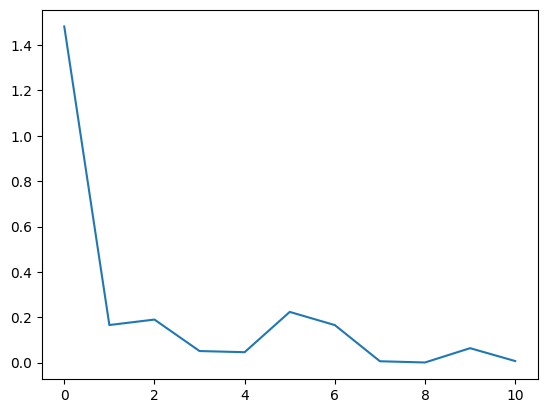

In [ ]:
import matplotlib.pyplot as plt
new_loss = [total_loss[l].detach().cpu() for l in range(len(total_loss)) if l%400==0]
plt.plot(new_loss)

In [ ]:
joblib.dump(new_loss, 'loss')

['loss']

In [ ]:
torch.save(model.state_dict(), '10_epoch_state_dict')
torch.save(model, '10_epoch_state_dict_model')

In [ ]:
# Number of parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

277649920

# Evaluation


In [ ]:
class FewShotSampler:
    '''
    Samples the data from csv to episodic data with query and support set in N-way K-shot
    n_wa: numeber of classes
    k_shot: sample for each class
    '''
    def __init__(self, k_shot, n_way):
        self.k_shot = k_shot
        self.n_way = n_way

    def extract_n_way_data(self, data):
        n_way_data = []
        for items in data:
            if len(set(items[1]))==self.n_way:
                n_way_data.append(items)

        return n_way_data

    def sample_data(self, n_way_data, full_data, n_episodes):
        episodes = []
        random.seed(42)
        for query in random.sample(n_way_data, min(n_episodes, len(n_way_data))):

            query_text = query[0]
            query_tags = query[1]

            query_tag_set = set(query_tags)

            final_query_set = [query_text, query_tags]

            support_data = []
            class_counts = {k: 0 for k in query_tag_set}

            for items in random.sample(full_data, len(full_data)):
                text, labels = items
                new_labels = []
                for i in range(len(labels)):
                    if labels[i] not in query_tag_set:
                        new_labels.append('O')
                    else:
                        new_labels.append(labels[i])


                tag_count_greater_k = False
                for tag in query_tag_set:
                    if [text, new_labels] in support_data:
                        break
                    if len(set(new_labels))<=1:
                        break
                    if len(support_data) >= self.n_way*self.k_shot:
                        break
                    if tag in new_labels:
                        for ent in new_labels:
                            if class_counts[ent]>=self.k_shot and ent!='O':
                                tag_count_greater_k = True
                        if not tag_count_greater_k:
                            support_data.append([text, new_labels])
                            for ent in set(new_labels):
                                class_counts[ent]+=1

            episodes.append({
                'query_set': final_query_set,
                'support_set': support_data
            })

            n_way_data.remove(query)

        return episodes

    def generate_episodes(self, reference_data, num_episodes):
        extracted_data = self.extract_n_way_data(reference_data)
        episodes = self.sample_data(extracted_data, reference_data, num_episodes)

        return episodes

In [ ]:
eval_sampler = FewShotSampler(1, 5)
eval_episodes = eval_sampler.generate_episodes(deepcopy(dataset), 500)

In [ ]:
tokenized_eval_episodes = tokenize_episodes(eval_episodes)

In [ ]:
joblib.dump(eval_episodes, 'eval_episodes')
joblib.dump(tokenized_eval_episodes, 'tokenized_eval_episodes')

['tokenized_eval_episodes']

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report

In [ ]:
f1_score([0, 1, 2, 2], [0, 1, 2, 3], average=None)

array([1.        , 1.        , 0.66666667, 0.        ])

In [ ]:
def eval(eval_eps):
  y_true = []
  y_preds = []
  all_i2l = []
  label2prototypes = {}
  model.eval()
  for i, episode in tqdm(enumerate(eval_eps), total=len(eval_eps)):
    query_set = episode['query_set']
    support_set = episode['support_set']
    num_classes = len(episode['label2idx'])
    i2l = {i: l for l, i in episode['label2idx'].items()}
    _, _, query_labels = query_set

    # Calculate predictions
    eval_distances = model(support_set, query_set, num_classes)[0]
    eval_preds = torch.argmin(eval_distances, dim=1).detach().cpu().numpy()

    y_true.append(query_labels.tolist())
    y_preds.append(eval_preds.tolist())
    all_i2l.append(i2l)

    del query_set
    del support_set
    del query_labels
    del num_classes

  return y_true, y_preds, all_i2l

In [ ]:
y_test, y_preds, i2l = eval(tokenized_eval_episodes)
len(y_test), len(y_preds)

100%|██████████| 401/401 [02:25<00:00,  2.75it/s]


(401, 401)

In [ ]:
f1_score(y_test[1], y_preds[1], average=None)

array([0.99497487, 1.        , 1.        , 1.        , 0.92307692])

In [ ]:
i2l[1]

{0: 'O', 1: 'WITNESS', 2: 'ORG', 3: 'DATE', 4: 'CASE_NUMBER'}

In [ ]:
print(classification_report(y_test[1], y_preds[1]))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         2
           4       0.86      1.00      0.92         6

    accuracy                           0.99       116
   macro avg       0.97      1.00      0.98       116
weighted avg       0.99      0.99      0.99       116



In [ ]:
def find_scores_per_class(y_test, y_preds, i2l, labels=labels):
  all_scores = {l: [] for l in labels}
  for true, pred, idx2label in zip(y_test, y_preds, i2l):
    scores = f1_score(true, pred, average=None)
    for i in range(len(scores)):
      lab = idx2label[i]
      all_scores[lab].append(scores[i])

  final_scores = {l: [] for l in labels}
  for k, v in all_scores.items():
    final_scores[k] = np.mean(v)

  return pd.DataFrame(final_scores, index=['Average F1 scores'])

In [ ]:
f1_scores = find_scores_per_class(y_test, y_preds, i2l, labels=labels)
f1_scores.T

,Average F1 scores
COURT,0.950621
JUDGE,0.885036
WITNESS,0.748553
STATUTE,0.973957
PETITIONER,0.633056
DATE,0.998063
OTHER_PERSON,0.843672
PRECEDENT,0.934335
O,0.990307
RESPONDENT,0.661426


# Production Pipeline

In [ ]:
def predict(episode, get_prototypes=False):

  episodes = tokenize_episodes(episode, eval=True)
  # print(episodes[0]['support_set'])
  query_set = episodes[0]['query_set']
  support_set = episodes[0]['support_set']
  label2idx = episodes[0]['label2idx']
  num_classes = len(label2idx)
  idx2label = {i: label for label, i in label2idx.items()}

  model.eval()
  with torch.inference_mode():

    if get_prototypes:
      eval_distances, all_prototypes = model(support_set, query_set, num_classes, get_prototypes)
      eval_preds = torch.argmin(eval_distances[0], dim=1).detach().cpu().numpy()
      predicted_class = [idx2label[pred] for pred in eval_preds]
      return predicted_class, all_prototypes, idx2label
    else:
      eval_distances = model(support_set, query_set, num_classes)[0]
      eval_preds = torch.argmin(eval_distances, dim=1).detach().cpu().numpy()

  predicted_class = [idx2label[pred] for pred in eval_preds]

  return predicted_class


In [ ]:
def tag_text(support_set, eval_query_text, get_prototypes=False):
  def remove_BIO(tags):
    normal_tags = []
    for tag in tags:
      normal_tags.append(tag.replace('I-', '').replace('B-', ''))
    return normal_tags

  new_support_set = []

  for support_item in support_set:
    s_text, s_tags = support_item
    new_s_tags = remove_BIO(s_tags)
    new_support_set.append([s_text, new_s_tags])

  episode = [{
      'query_set': [eval_query_text, []],
      'support_set': new_support_set
  }]
  if get_prototypes:
    preds, all_prototypes, idx2label = predict(episode, get_prototypes)
    tokens = xlmr_tokenizer(eval_query_text, is_split_into_words=True).tokens()
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"]), all_prototypes, idx2label

  preds = predict(episode, get_prototypes)
  tokens = xlmr_tokenizer(eval_query_text, is_split_into_words=True).tokens()
  return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [ ]:
eval_query_text = ['allow', 'this', 'appeal', 'and', 'reverse', 'the', 'decision', 'of', 'the', 'Bombay', 'High', 'Court', '.']
eval_query_tags = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COURT', 'I-COURT', 'I-COURT', 'O']
eval_support_text = ['The', 'husband', 'is', 'an', 'Advocate', 'practicing', 'in', 'this', 'Court', 'as', 'well', 'as', 'in', 'Delhi', 'High', 'Court', '.']
eval_support_tags = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COURT', 'I-COURT', 'I-COURT', 'O']

In [ ]:
print(eval_query_tags)
tag_text([[eval_support_text, eval_support_tags]], eval_query_text)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COURT', 'I-COURT', 'I-COURT', 'O']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Tokens,<s>,▁allow,▁this,▁appeal,▁and,▁rever,se,▁the,▁decision,▁of,▁the,▁Bomba,y,▁High,▁Court,▁,.,</s>
Tags,O,O,O,O,O,O,O,O,O,O,O,COURT,COURT,COURT,COURT,O,O,O


In [ ]:
eval_query_text = ['Another', 'defendant', "'s", 'witness', ',', 'Mahesh', 'Dutt', 'Bhargava', ',', 'advocate', ',', 'testifies', 'that', 'there', 'was', 'no', 'danger', 'of', 'any', 'breach', 'of', 'the', 'peace', '.']
eval_query_tags = ['O', 'O', 'O', 'O', 'O', 'B-WITNESS', 'I-WITNESS', 'I-WITNESS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
eval_support_text = ['PW5', 'K.', 'Mahapatra', ',', 'Chief', 'Vigilance', 'Officer', 'admits', 'that', 'no', 'departmental', 'enquiry', 'was', 'conducted', 'against', 'any', 'public', 'servant', 'in', 'this', 'case', '.']
eval_support_tags = ['O', 'B-WITNESS', 'I-WITNESS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [ ]:
print(eval_query_tags)
tag_text([[eval_support_text, eval_support_tags]], eval_query_text)

['O', 'O', 'O', 'O', 'O', 'B-WITNESS', 'I-WITNESS', 'I-WITNESS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
Tokens,<s>,▁Another,▁defend,ant,▁',s,▁witness,▁,",",▁Ma,...,▁of,▁any,▁bre,ach,▁of,▁the,▁peace,▁,.,</s>
Tags,O,O,O,O,O,O,O,O,O,WITNESS,...,O,O,O,O,O,O,O,O,O,O


In [ ]:
eval_query_text = ['Ronit', 'is', 'going', 'to', 'Patiala']
eval_query_tags = ['PER', 'O', 'O', 'O', 'LOC']
eval_support_text = ['Tinor', 'lives', 'in', 'Gujarat']
eval_support_tags = ['PER', 'O', 'O', 'LOC']

In [ ]:
print(eval_query_tags)
tag_text([[eval_support_text, eval_support_tags]], eval_query_text)

['PER', 'O', 'O', 'O', 'LOC']


,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Ron,it,▁is,▁going,▁to,▁Pati,ala,</s>
Tags,O,PER,PER,O,O,O,LOC,LOC,O


In [ ]:
eval_query_text = ['Apple', 'Inc.', 'is', 'planning', 'to', 'open', 'a', 'new', 'store', 'in', 'San', 'Francisco', '.']
eval_query_tags = ['ORG', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'LOC', 'O']
eval_support_text = ['Hello', 'I', 'am', 'John', 'Doe', ',', 'working', 'at', 'XYZ', 'Corp', 'in', 'New', 'York', '.']
eval_support_tags = ['O', 'O', 'O', 'PER', 'PER', 'O', 'O', 'O', 'ORG', 'ORG', 'O', 'LOC', 'LOC', 'O']

In [ ]:
print(eval_query_tags)
preds = tag_text([[eval_support_text, eval_support_tags]], eval_query_text)
preds

['ORG', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'LOC', 'O']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,<s>,▁Apple,▁Inc,.,▁is,▁planning,▁to,▁open,▁a,▁new,▁store,▁in,▁San,▁Francisco,▁,.,</s>
Tags,O,ORG,ORG,ORG,O,O,O,O,O,O,O,O,LOC,LOC,O,O,O


In [ ]:
eval_query_text = ['Satya', 'Nadella', 'announced', 'that', 'Microsoft', 'revealed', 'plans', 'to', 'expand', 'operations', 'to', 'Asia', 'by', 'the', 'end', 'of', '2024', '.']
eval_query_tags = ['PER', 'PER', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O', 'DATE', 'DATE', 'DATE', 'O']
eval_support_text = ['Elon', 'Musk', 'announced', 'that', 'Tesla', ' ,' , 'Inc.', 'will', 'open', 'a', 'new', 'factory', 'in', 'Berlin', 'Germany', 'next', 'year', '.']
eval_support_tags = ['PER', 'PER', 'O', 'O', 'ORG', 'ORG', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'LOC', 'DATE', 'DATE', 'O']

In [ ]:
print(eval_query_tags)
preds, protos, test_i2l = tag_text([[eval_support_text, eval_support_tags]], eval_query_text, get_prototypes=True)
preds

['PER', 'PER', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O', 'DATE', 'DATE', 'DATE', 'O']


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁Satya,▁Na,della,▁announced,▁that,▁Microsoft,▁reveal,ed,▁plans,...,▁Asia,▁by,▁the,▁end,▁of,▁20,24,▁,.,</s>
Tags,O,PER,PER,PER,O,O,ORG,O,O,O,...,LOC,DATE,O,DATE,DATE,DATE,DATE,O,O,O


In [ ]:
min_len = min([len(p) for p in protos])
new_protos = [p[:min_len] for p in protos]
final_protos = [[] for p in new_protos]
for i, p in enumerate(new_protos):
    final_protos[i].append(p[0].cpu().numpy())
    final_protos[i].append(p[1].cpu().numpy())

In [ ]:
len(final_protos), len(final_protos[0])

(5, 2)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
flat_data = np.array(final_protos).reshape(-1, 256)

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_data)

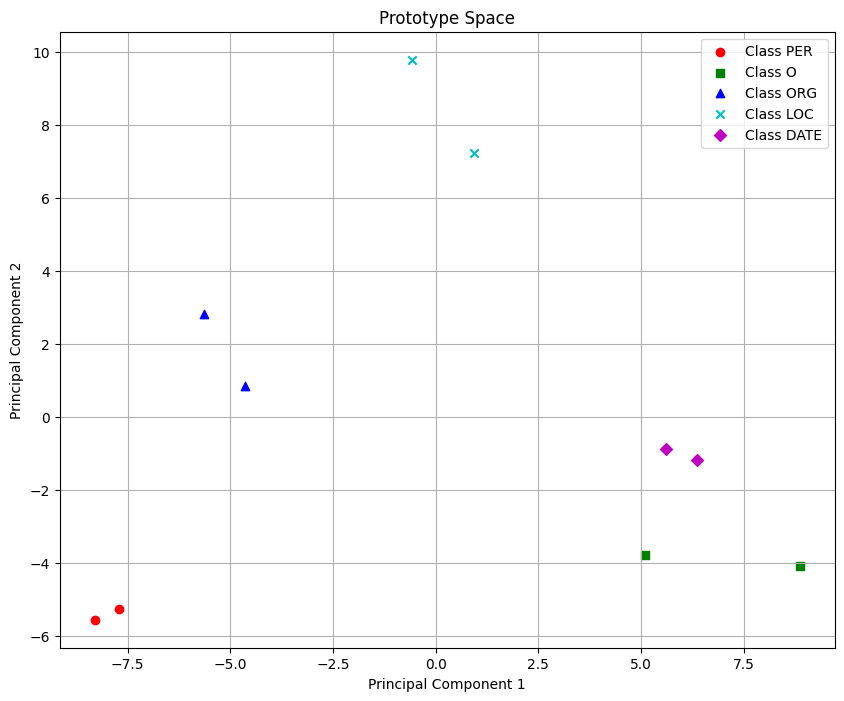

In [ ]:
# Convert PCA result back to a list of list
pca_per_class = [pca_result[i*2:(i+1)*2] for i in range(5)]  # Split into 5 classes

# Plot the PCA result for each class
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b', 'c', 'm']  # Example colors for each class
markers = ['o', 's', '^', 'x', 'D']  # Example markers for each class

for i, class_data in enumerate(pca_per_class):
    class_data = np.array(class_data)
    plt.scatter(class_data[:, 0], class_data[:, 1], color=colors[i], marker=markers[i],
                label=f'Class {test_i2l[i]}')

plt.title('Prototype Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()